## Contextualizing variant calls by local identity 

In [1]:
import pandas as pd
from pathlib import Path
import glob
import os
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Load in all pairs df 

# Directory containing CSV files
pairwise_dist_dir = "/private/groups/patenlab/mira/centrolign/batch_submissions/centrolign/release2_QC_v2/all_pairs/distance_matrices/"  # this should be a folder path

# Collect all matching files
files = glob.glob(os.path.join(pairwise_dist_dir, "*_r2_QC_v2_centrolign_pairwise_distance.csv"))

all_dfs = []

for f in files:
    # Extract chr from filename
    # e.g. filename: "chr3_r2_QC_v2_centrolign_pairwise_distance.csv"
    basename = os.path.basename(f)
    chr_val = basename.split("_")[0]   # 'chr3'

    # Read CSV
    df = pd.read_csv(f, header=None,names=["sample1", "sample2", "direct_pairwise_dist","chr"])
    df["chr"] = chr_val
    all_dfs.append(df)

# Combine into one dataframe
all_pairs_dist_df = pd.concat(all_dfs, ignore_index=True)

all_pairs_dist_df["sample_pair"] = (
    all_pairs_dist_df[["sample1", "sample2"]]
    .apply(lambda x: "_".join(sorted(x)), axis=1)
)

all_pairs_dist_df.head()

,sample1,sample2,direct_pairwise_dist,chr,sample_pair
0,HG03098.1,HG03784.1,0.942968,chr6,HG03098.1_HG03784.1
1,HG03098.1,NA20752.2,0.974936,chr6,HG03098.1_NA20752.2
2,HG01978.2,NA19835.1,0.999883,chr6,HG01978.2_NA19835.1
3,HG00741.1,NA18522.1,0.999869,chr6,HG00741.1_NA18522.1
4,HG00408.1,HG01496.1,0.606856,chr6,HG00408.1_HG01496.1


In [3]:
# Get list of sample pairs with dist < 0.2 
all_pairs_dist_df["sample_pair"] = (
    all_pairs_dist_df[["sample1", "sample2"]]
    .apply(lambda x: "_".join(sorted(x)), axis=1)
)

# Subset to distances < 0.2
allowed_pairs = set(
    all_pairs_dist_df.loc[all_pairs_dist_df["direct_pairwise_dist"] < 0.2, "sample_pair"]
)

### Starting with all SNVs (unfiltered)

In [8]:
base_path = Path("/private/groups/patenlab/mira/centrolign/analysis/CDR_variant_regression/SNVs_pairwise_raw")

# BED column names as given
columns = [
    "contig",
    "start",
    "end",
    "local_identity",
    "CDR_dist",
    "SNV_count1",
    "SNV_count2",
    "windowsize",
    "SNV_rate",
]

dfs = []

for chr_dir in base_path.glob("chr*"):
    if not chr_dir.is_dir():
        continue

    chr_name = chr_dir.name

    for bed_file in chr_dir.glob("*.bed"):
        # Extract sample names
        name_part = bed_file.name.split(".SNVs.all_snvs.local_id_CDR_dist.bed")[0]
        sample1, sample2 = name_part.split("_", 1)
        sample_pair = "_".join(sorted([sample1, sample2]))

        # Skip pairs not in allowed set
        if sample_pair not in allowed_pairs:
            continue

        df = pd.read_csv(
            bed_file,
            sep="\t",
            header=None,
            names=columns,
        )

        df["chr"] = chr_name
        df["sample1"] = sample1
        df["sample2"] = sample2
        df["sample_pair"] = sample_pair
        
        df = df.drop(columns=["SNV_count2", "windowsize"])

        dfs.append(df)

# Combine only the filtered data
all_snvs_df = pd.concat(dfs, ignore_index=True)


/data/tmp/ipykernel_1490520/728912381.py:51: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_snvs_df = pd.concat(dfs, ignore_index=True)


In [9]:
all_snvs_df.head()

,contig,start,end,local_identity,CDR_dist,SNV_count1,SNV_rate,chr,sample1,sample2,sample_pair
0,HG00741#1#CM087903.1,50996952,51001951,97.69,1923992,0,0.0,chr11,HG00741.1,HG00272.2,HG00272.2_HG00741.1
1,HG00741#1#CM087903.1,51001952,51006951,96.95,1918992,0,0.0,chr11,HG00741.1,HG00272.2,HG00272.2_HG00741.1
2,HG00741#1#CM087903.1,51006952,51011951,96.75,1913992,0,0.0,chr11,HG00741.1,HG00272.2,HG00272.2_HG00741.1
3,HG00741#1#CM087903.1,51011952,51016951,96.61,1908992,0,0.0,chr11,HG00741.1,HG00272.2,HG00272.2_HG00741.1
4,HG00741#1#CM087903.1,51016952,51021951,96.93,1903992,0,0.0,chr11,HG00741.1,HG00272.2,HG00272.2_HG00741.1


/data/tmp/ipykernel_3853436/46595265.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_snv_rate = all_snvs_df.groupby('identity_bin')['SNV_rate'].mean().reset_index()


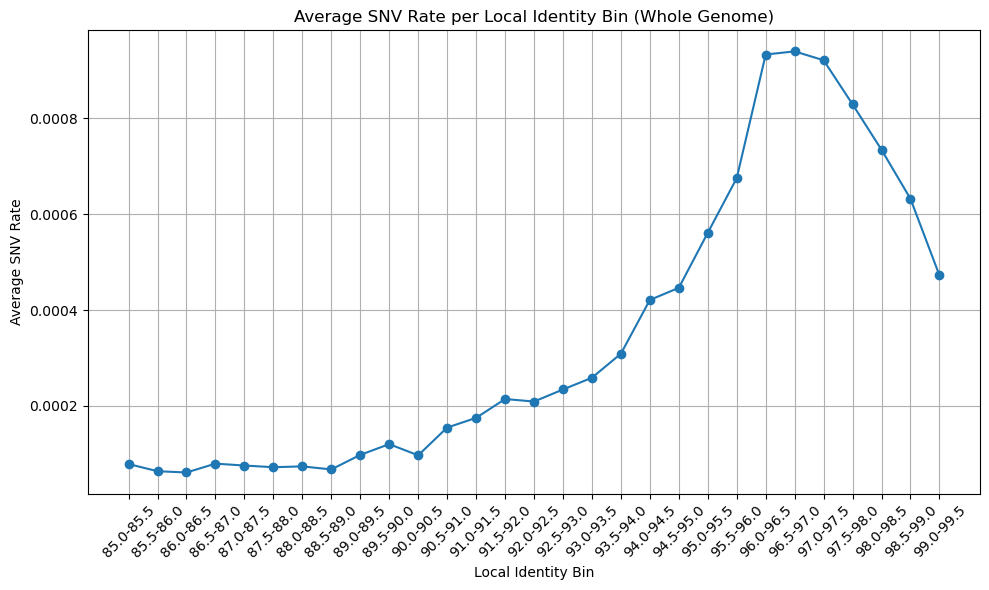

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Example: create bins from 0 to 1 in steps of 0.05
bins = np.arange(85, 100, .5)
labels = [f"{round(b,2)}-{round(bins[i+1],2)}" for i, b in enumerate(bins[:-1])]

# Add a new column 'identity_bin' to the DataFrame
all_snvs_df['identity_bin'] = pd.cut(all_snvs_df['local_identity'], bins=bins, labels=labels, include_lowest=True)

avg_snv_rate = all_snvs_df.groupby('identity_bin')['SNV_rate'].mean().reset_index()

plt.figure(figsize=(10,6))
plt.plot(avg_snv_rate['identity_bin'], avg_snv_rate['SNV_rate'], marker='o')
plt.xticks(rotation=45)
plt.xlabel('Local Identity Bin')
plt.ylabel('Average SNV Rate')
plt.title('Average SNV Rate per Local Identity Bin (Whole Genome)')
plt.grid(True)
plt.tight_layout()
plt.show()



/data/tmp/ipykernel_3853436/99450521.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  genome_stats = all_snvs_df.groupby('identity_bin').agg(


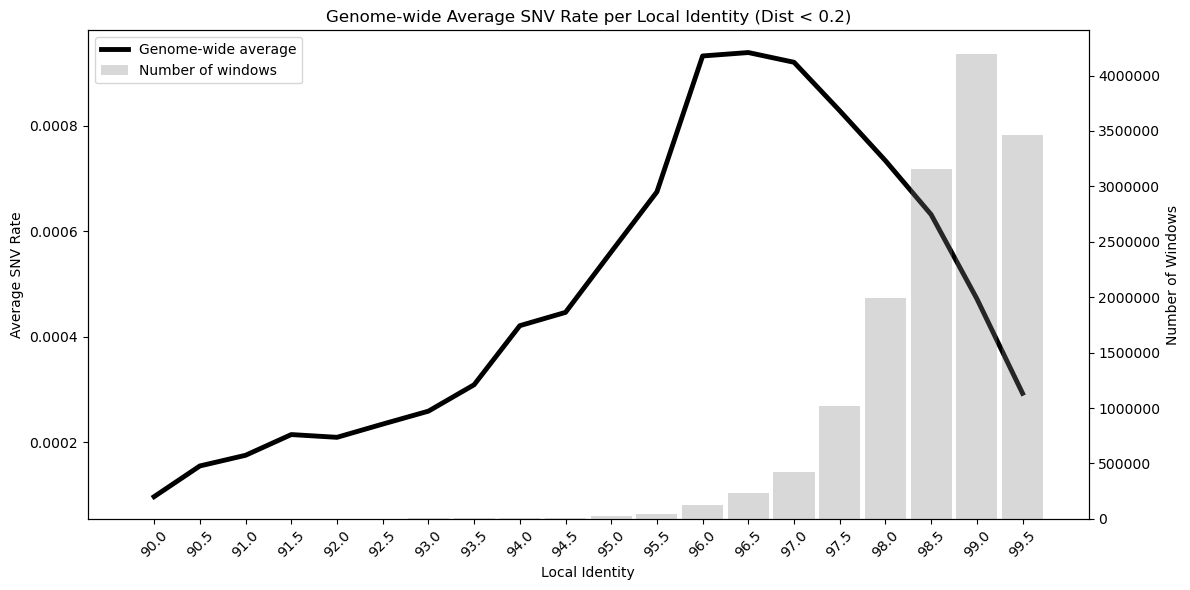

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Create bins from 90 to 100 in steps of 0.5
bins = np.arange(90, 100.5, 0.5)
bin_edges = bins[:-1]  # left edges

# Add identity_bin (keep intervals for grouping)
all_snvs_df['identity_bin'] = pd.cut(
    all_snvs_df['local_identity'],
    bins=bins,
    include_lowest=True
)

# Genome-wide statistics per bin
genome_stats = all_snvs_df.groupby('identity_bin').agg(
    SNV_rate_avg=('SNV_rate', 'mean'),
    window_count=('SNV_rate', 'count')
).reset_index()

# Convert Interval → numeric (left bin edge)
genome_stats['bin_left'] = genome_stats['identity_bin'].apply(lambda x: x.left)

# Plot
fig, ax = plt.subplots(figsize=(12, 6))

# Primary y-axis: genome-wide average SNV rate
ax.plot(
    genome_stats['bin_left'],
    genome_stats['SNV_rate_avg'],
    color='black',
    linewidth=3.5,
    label='Genome-wide average'
)

ax.set_xlabel('Local Identity')
ax.set_ylabel('Average SNV Rate')
ax.grid(False)

# Secondary y-axis: number of windows per bin
ax2 = ax.twinx()
ax2.bar(
    genome_stats['bin_left'],
    genome_stats['window_count'],
    width=0.45,
    alpha=0.3,
    color='gray',
    label='Number of windows'
)
ax2.set_ylabel('Number of Windows')
ax2.grid(False)
ax2.ticklabel_format(axis='y', style='plain')
ax2.get_yaxis().get_offset_text().set_visible(False)

# X-axis ticks: bin edges only
ax.set_xticks(bin_edges)
ax.set_xticklabels([str(b) for b in bin_edges], rotation=45)

# Title
ax.set_title(
    'Genome-wide Average SNV Rate per Local Identity (Dist < 0.2)'
)

# Legend (combined)
lines, labels1 = ax.get_legend_handles_labels()
bars, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines + bars, labels1 + labels2, loc='upper left')

plt.tight_layout()
plt.show()



/data/tmp/ipykernel_3853436/2924629317.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  chrom_avg = all_snvs_df.groupby(['chr', 'identity_bin']).agg(


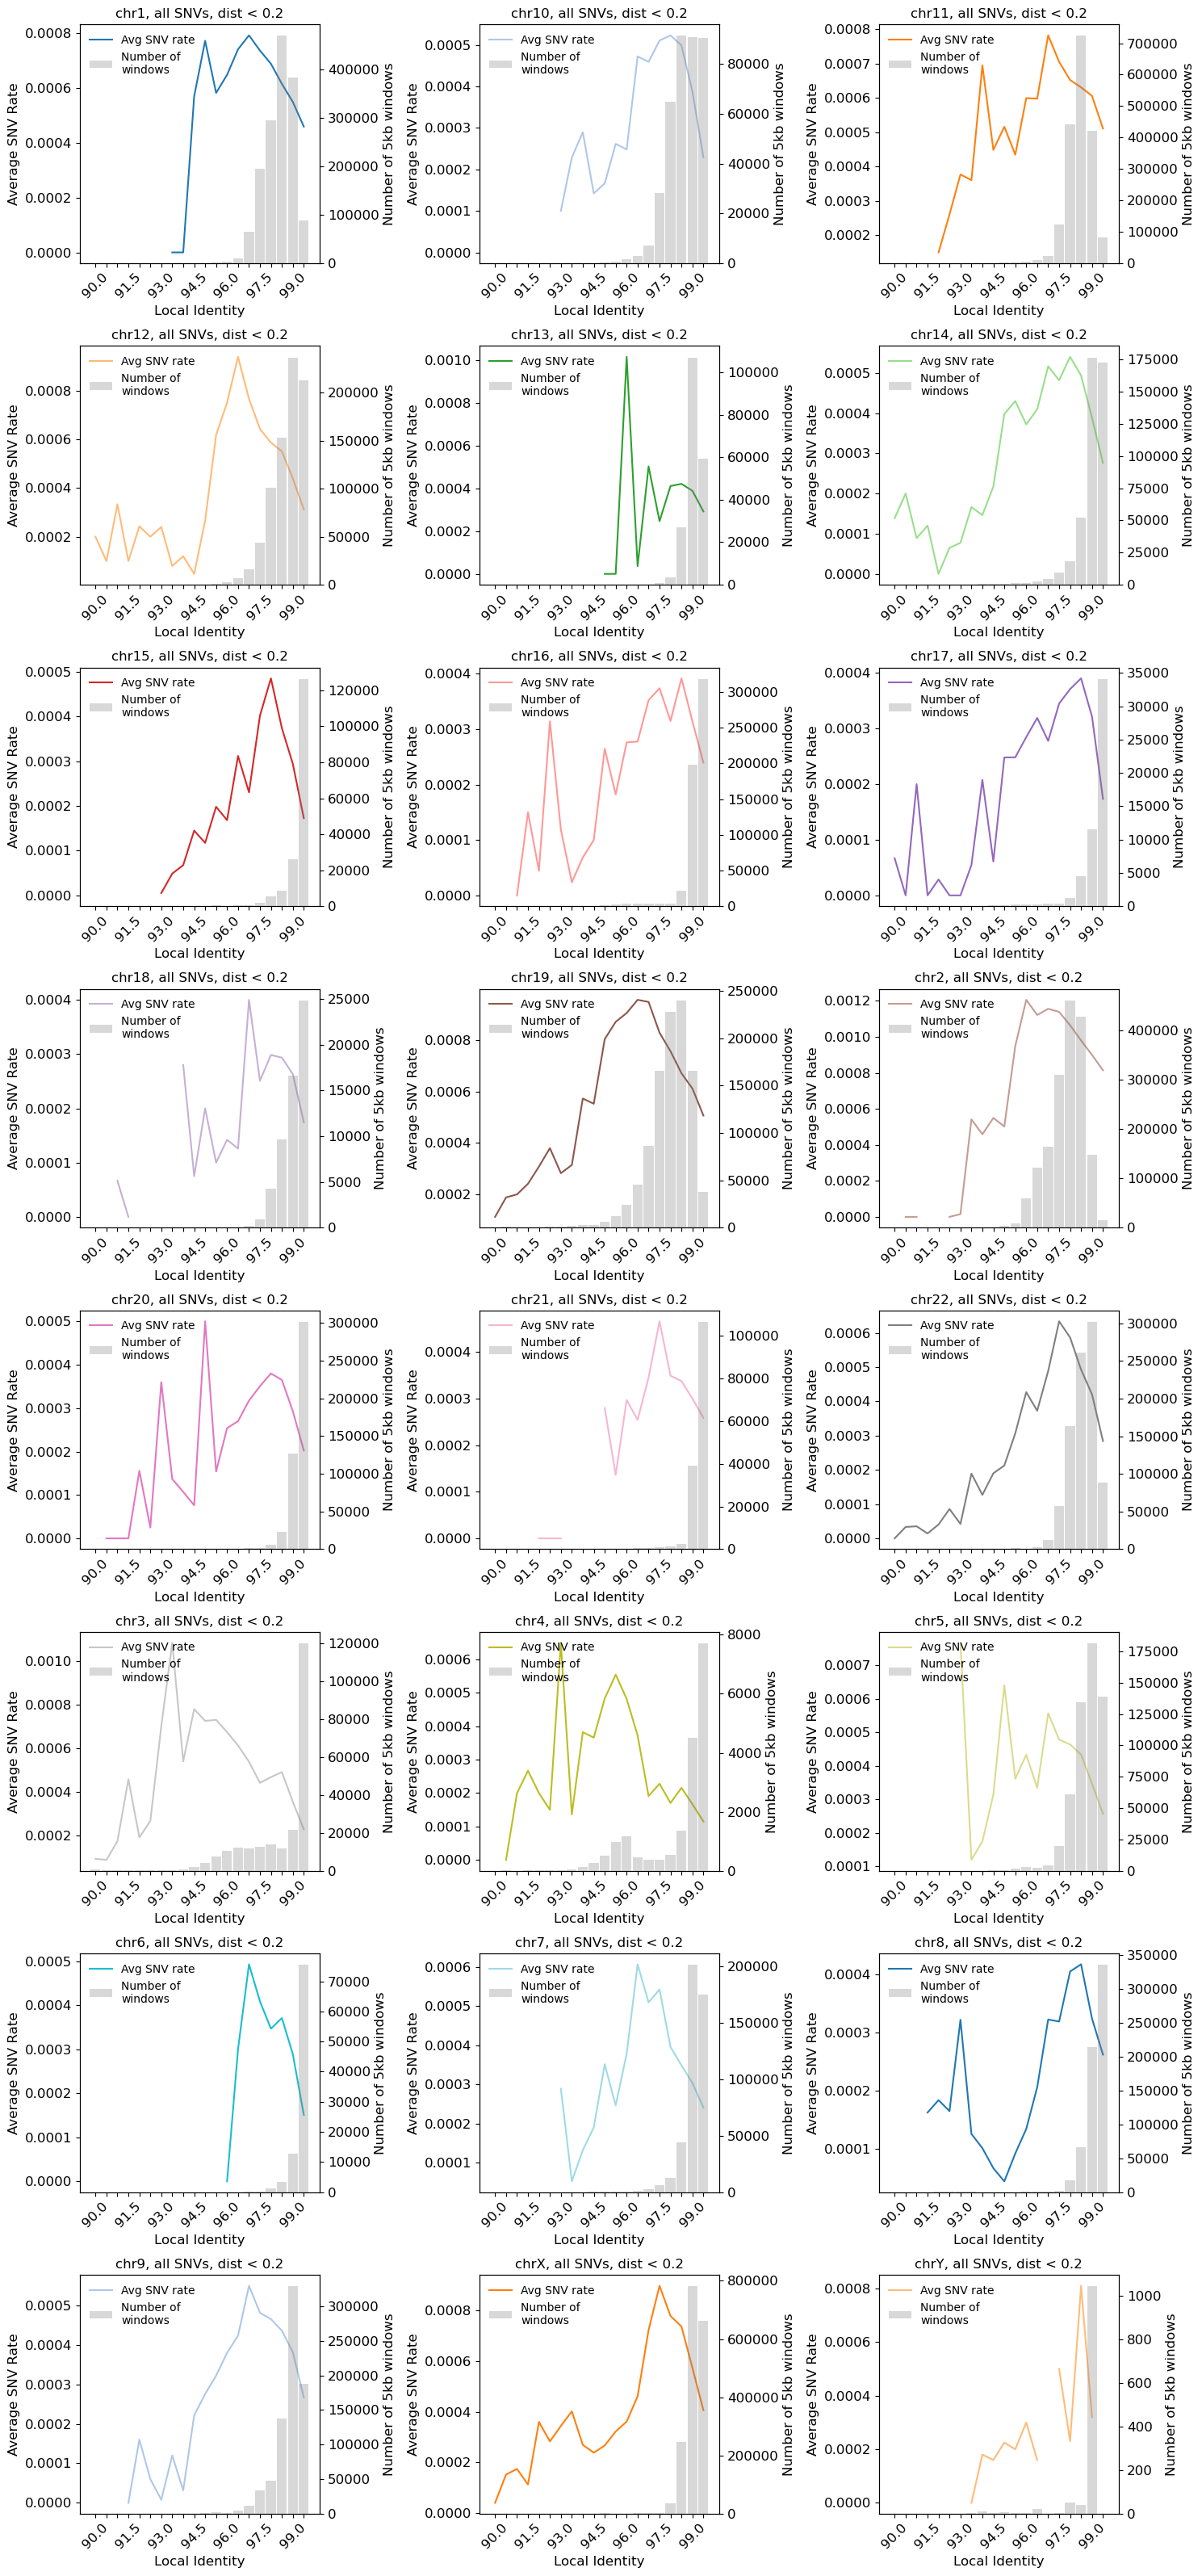

In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Create bins from 85 to 100 in steps of 0.5
bins = np.arange(90, 100.5, 0.5)  # bin edges
bin_left_edges = bins[:-1]  # left edges for plotting and labels

# Add 'identity_bin' column
all_snvs_df['identity_bin'] = pd.cut(all_snvs_df['local_identity'], bins=bins, include_lowest=True)

# Compute average SNV rate per chromosome per bin
chrom_avg = all_snvs_df.groupby(['chr', 'identity_bin']).agg(
    SNV_rate_avg=('SNV_rate', 'mean'),
    window_count=('SNV_rate', 'count')  # number of windows in the bin
).reset_index()

# Convert 'identity_bin' (intervals) to numeric x-values: use left edge
chrom_avg['bin_left'] = chrom_avg['identity_bin'].apply(lambda x: x.left)

# List of chromosomes
chromosomes = chrom_avg['chr'].unique()
n_chroms = len(chromosomes)

# Determine grid size for subplots
n_cols = 3
n_rows = int(np.ceil(n_chroms / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*5, n_rows*4), sharey=False)
axes = axes.flatten()

# Colormap for chromosome lines
colors = plt.cm.tab20.colors  # up to 20 distinct colors
N = 3  # Show every Nth x-axis label

for i, chrom in enumerate(chromosomes):
    ax = axes[i]
    chrom_data = chrom_avg[chrom_avg['chr'] == chrom]
    
    l1, = ax.plot(
        chrom_data['bin_left'],
        chrom_data['SNV_rate_avg'],
        color=colors[i % len(colors)],
        label='Avg SNV rate'
    )
    
    ax2 = ax.twinx()
    l2 = ax2.bar(
        chrom_data['bin_left'],
        chrom_data['window_count'],
        width=0.45,
        alpha=0.3,
        color='gray',
        label='Number of windows'
    )
    
    ax.set_ylabel('Average SNV Rate',fontsize=12)
    ax2.set_ylabel('Number of 5kb windows',fontsize=12)

    ax.grid(False)
    ax2.grid(False)

    # X ticks
    tick_labels = [
        str(bin_left_edges[j]) if j % N == 0 else ''
        for j in range(len(bin_left_edges))
    ]
    ax.set_xticks(bin_left_edges)
    ax.set_xticklabels(tick_labels, rotation=45,fontsize=12)
    ax.tick_params(axis='both', labelsize=12)
    ax2.tick_params(axis='y', labelsize=12)

    ax.set_xlabel("Local Identity",fontsize=12)
    ax.set_title(f'{chrom}, all SNVs, dist < 0.2',fontsize=12)

    ax.legend(
        handles=[l1, l2],
        labels=['Avg SNV rate', 'Number of\nwindows'],
        loc='upper left',
        frameon=False
    )

# Remove empty subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


### Short indels 

In [10]:
base_path = Path("/private/groups/patenlab/mira/centrolign/analysis/CDR_variant_regression/short_indels_triangles/")

# BED column names as given
columns = [
    "contig",
    "start",
    "end",
    "local_identity",
    "CDR_dist",
    "par_count",
    "par_rate",
    "trap_count",
    "trap_rate",
    "tri_count",
    "tri_rate"
]

dfs = []

for chr_dir in base_path.glob("chr*"):
    if not chr_dir.is_dir():
        continue

    chr_name = chr_dir.name

    for bed_file in chr_dir.glob("*.bed"):
        # Extract sample names
        name_part = bed_file.name.split(".all_short_indel_counts.bed")[0]
        sample1, sample2 = name_part.split("_", 1)
        sample_pair = "_".join(sorted([sample1, sample2]))

        # Skip pairs not in allowed set
        if sample_pair not in allowed_pairs:
            continue

        df = pd.read_csv(
            bed_file,
            sep="\t",
            header=None,
            names=columns,
        )

        df["chr"] = chr_name
        df["sample1"] = sample1
        df["sample2"] = sample2
        df["sample_pair"] = sample_pair

        dfs.append(df)

# Combine only the filtered data
all_short_indels_df = pd.concat(dfs, ignore_index=True)

/data/tmp/ipykernel_1490520/2179722358.py:51: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_short_indels_df = pd.concat(dfs, ignore_index=True)


In [51]:
all_short_indels_df.head()

,contig,start,end,local_identity,CDR_dist,par_count,par_rate,trap_count,trap_rate,tri_count,tri_rate,chr,sample1,sample2,sample_pair,identity_bin
0,HG01934#1#CM088845.1,51051721,51056720,97.66,1755010,0,0.0,0,0.0000,0,0.000000,chr11,HG01934.1,HG01981.2,HG01934.1_HG01981.2,"(97.5, 98.0]"
1,HG01934#1#CM088845.1,51056721,51061720,96.87,1750010,0,0.0,0,0.0000,0,0.000000,chr11,HG01934.1,HG01981.2,HG01934.1_HG01981.2,"(96.5, 97.0]"
2,HG01934#1#CM088845.1,51061721,51066720,97.08,1745010,0,0.0,0,0.0000,0,0.000000,chr11,HG01934.1,HG01981.2,HG01934.1_HG01981.2,"(97.0, 97.5]"
3,HG01934#1#CM088845.1,51066721,51071720,97.21,1740010,0,0.0,1,0.0002,3,0.000800,chr11,HG01934.1,HG01981.2,HG01934.1_HG01981.2,"(97.0, 97.5]"
4,HG01934#1#CM088845.1,51071721,51076720,98.34,1735010,0,0.0,2,0.0006,15,0.003201,chr11,HG01934.1,HG01981.2,HG01934.1_HG01981.2,"(98.0, 98.5]"


/data/tmp/ipykernel_3853436/3063508179.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  genome_stats = all_short_indels_df.groupby('identity_bin').agg(


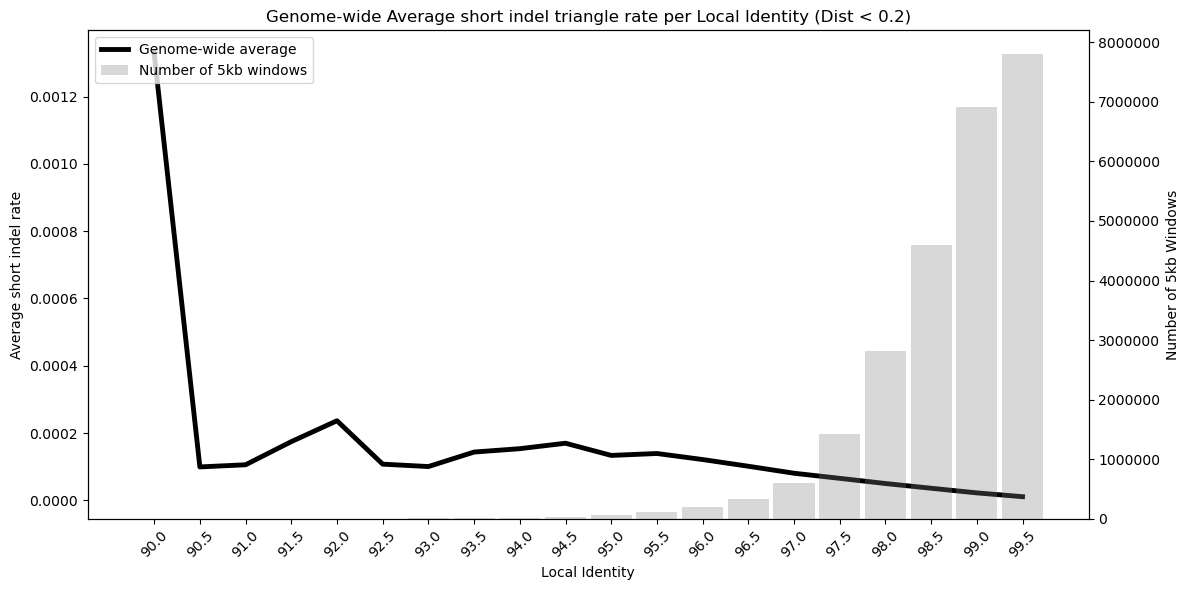

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Create bins from 90 to 100 in steps of 0.5
bins = np.arange(90, 100.5, 0.5)
bin_edges = bins[:-1]  # left edges

# Add identity_bin (keep intervals for grouping)
all_short_indels_df['identity_bin'] = pd.cut(
    all_short_indels_df['local_identity'],
    bins=bins,
    include_lowest=True
)

# Genome-wide statistics per bin
genome_stats = all_short_indels_df.groupby('identity_bin').agg(
    short_indel_rate_avg=('tri_rate', 'mean'),
    window_count=('tri_rate', 'count')
).reset_index()

# Convert Interval → numeric (left bin edge)
genome_stats['bin_left'] = genome_stats['identity_bin'].apply(lambda x: x.left)

# Plot
fig, ax = plt.subplots(figsize=(12, 6))

# Primary y-axis: genome-wide average SNV rate
ax.plot(
    genome_stats['bin_left'],
    genome_stats['short_indel_rate_avg'],
    color='black',
    linewidth=3.5,
    label='Genome-wide average'
)

ax.set_xlabel('Local Identity')
ax.set_ylabel('Average short indel rate')
ax.grid(False)

# Secondary y-axis: number of windows per bin
ax2 = ax.twinx()
ax2.bar(
    genome_stats['bin_left'],
    genome_stats['window_count'],
    width=0.45,
    alpha=0.3,
    color='gray',
    label='Number of 5kb windows'
)
ax2.set_ylabel('Number of 5kb Windows')
ax2.grid(False)
ax2.ticklabel_format(axis='y', style='plain')
ax2.get_yaxis().get_offset_text().set_visible(False)

# X-axis ticks: bin edges only
ax.set_xticks(bin_edges)
ax.set_xticklabels([str(b) for b in bin_edges], rotation=45)

# Title
ax.set_title(
    'Genome-wide Average short indel triangle rate per Local Identity (Dist < 0.2)'
)

# Legend (combined)
lines, labels1 = ax.get_legend_handles_labels()
bars, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines + bars, labels1 + labels2, loc='upper left')

plt.tight_layout()
plt.show()


/data/tmp/ipykernel_3853436/3263480837.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  chrom_avg = all_short_indels_df.groupby(['chr', 'identity_bin']).agg(


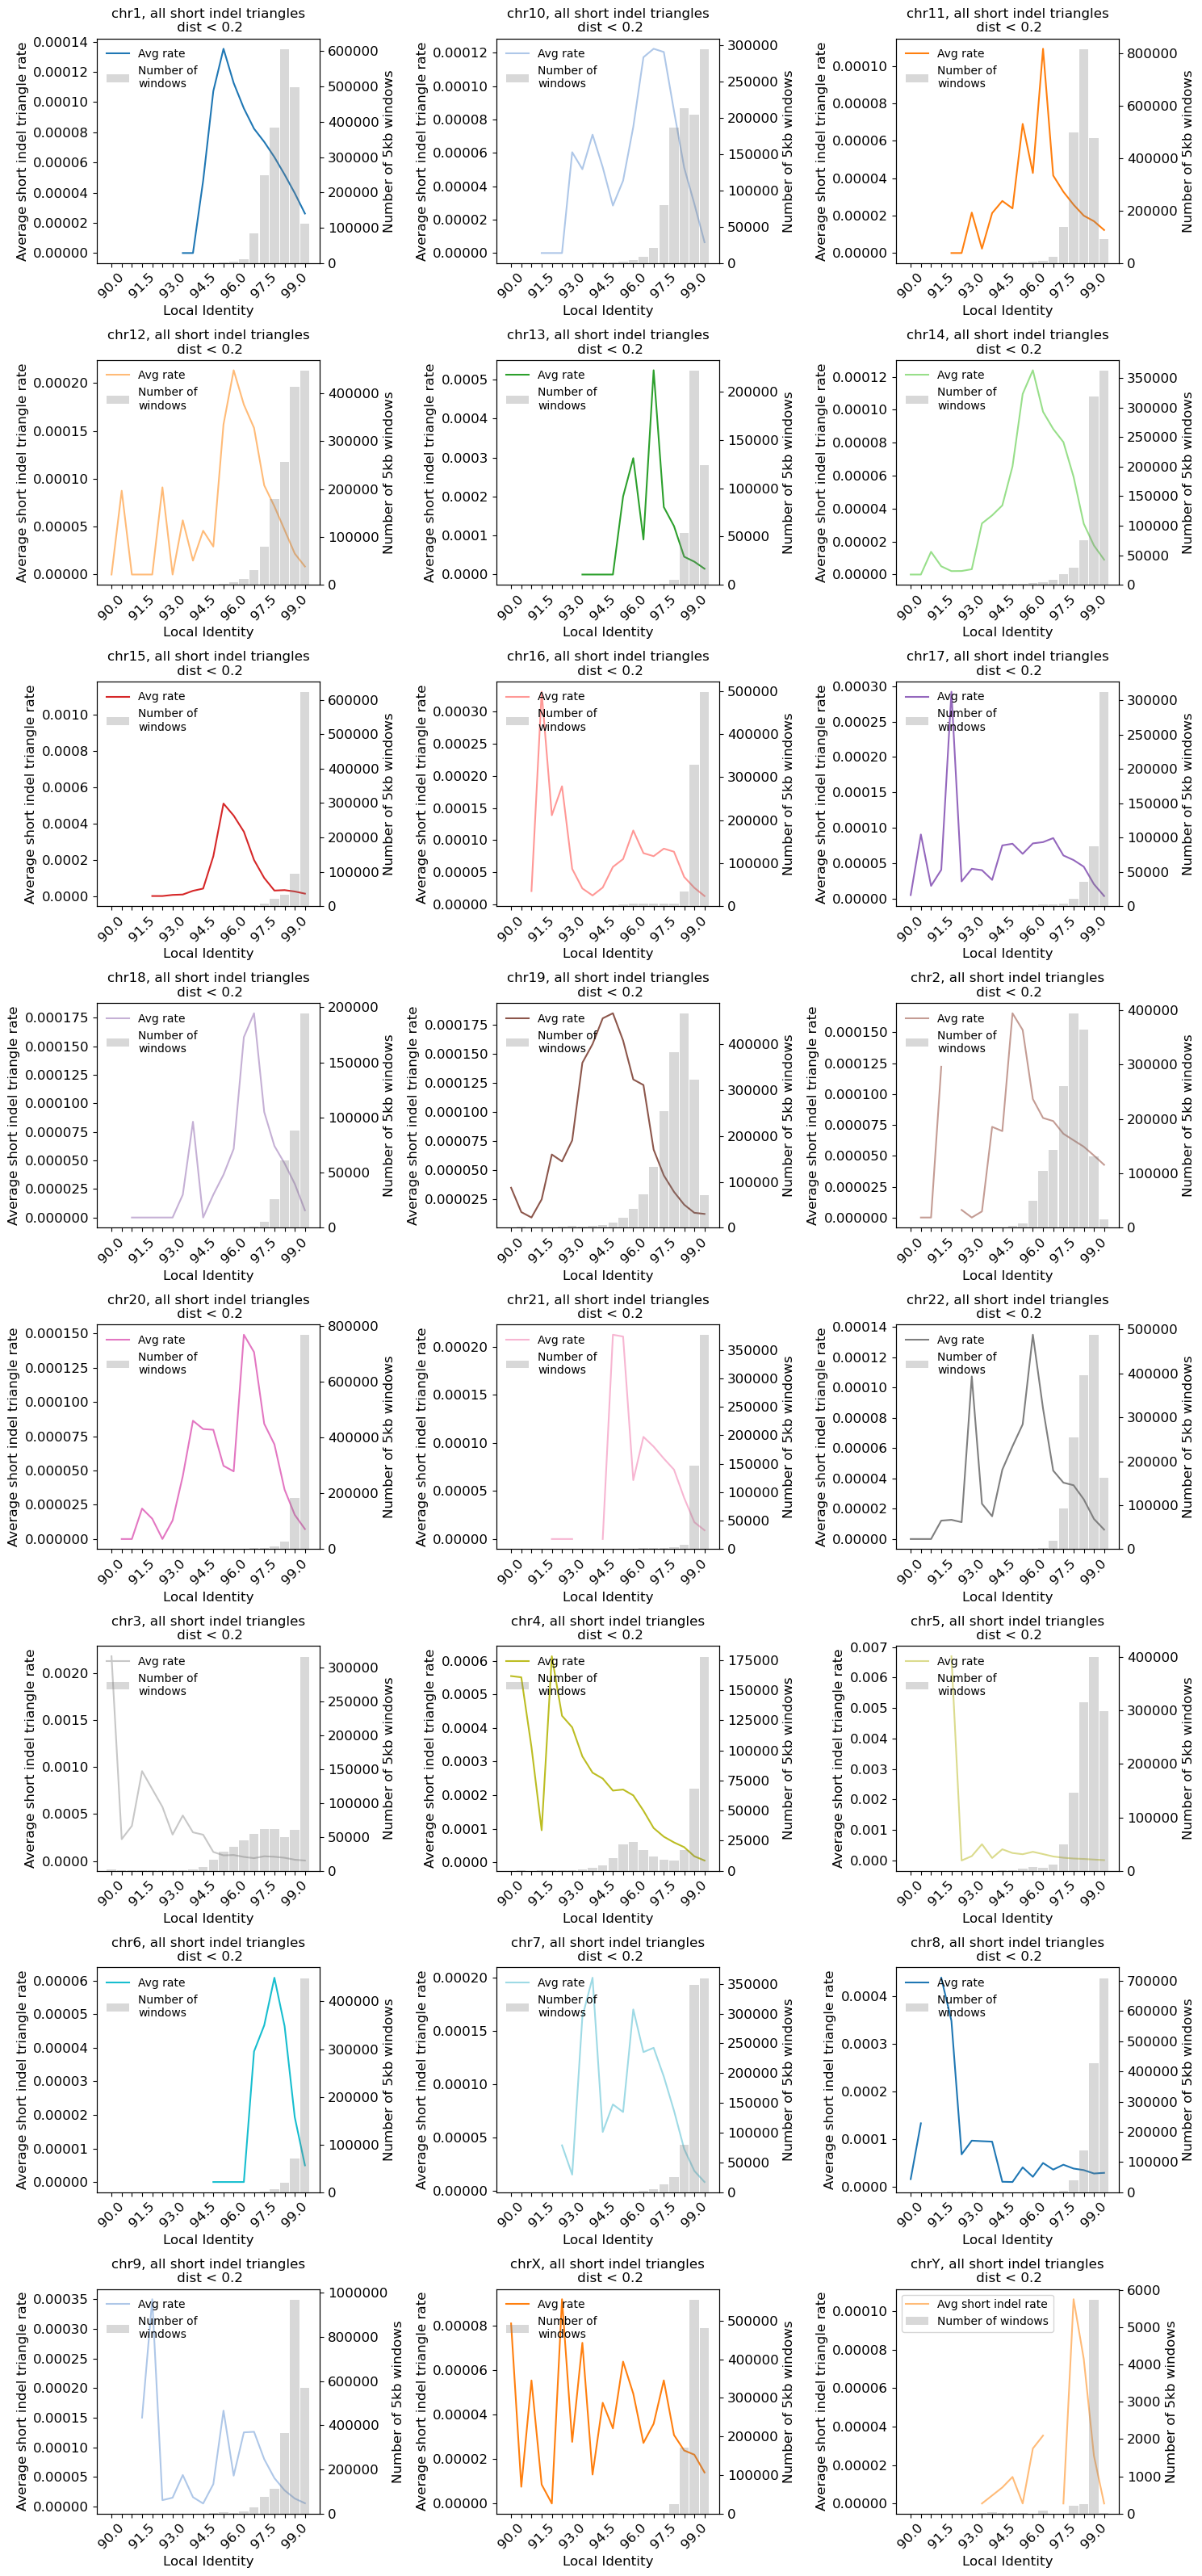

In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import ScalarFormatter

# Create bins from 85 to 100 in steps of 0.5
bins = np.arange(90, 100.5, 0.5)  # bin edges
bin_left_edges = bins[:-1]  # left edges for plotting and labels

# Add 'identity_bin' column
all_short_indels_df['identity_bin'] = pd.cut(all_short_indels_df['local_identity'], bins=bins, include_lowest=True)

# Compute average SNV rate per chromosome per bin
chrom_avg = all_short_indels_df.groupby(['chr', 'identity_bin']).agg(
    short_indel_rate_avg=('tri_rate', 'mean'),
    window_count=('tri_rate', 'count')  # number of windows in the bin
).reset_index()

# Convert 'identity_bin' (intervals) to numeric x-values: use left edge
chrom_avg['bin_left'] = chrom_avg['identity_bin'].apply(lambda x: x.left)

# List of chromosomes
chromosomes = chrom_avg['chr'].unique()
n_chroms = len(chromosomes)

# Determine grid size for subplots
n_cols = 3
n_rows = int(np.ceil(n_chroms / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*5, n_rows*4), sharey=False)
axes = axes.flatten()

# Colormap for chromosome lines
colors = plt.cm.tab20.colors  # up to 20 distinct colors
N = 3  # Show every Nth x-axis label

for i, chrom in enumerate(chromosomes):
    ax = axes[i]
    chrom_data = chrom_avg[chrom_avg['chr'] == chrom]
    
    l1, = ax.plot(
        chrom_data['bin_left'],
        chrom_data['short_indel_rate_avg'],
        color=colors[i % len(colors)],
        label='Avg short indel rate'
    )
    
    ax2 = ax.twinx()
    l2 = ax2.bar(
        chrom_data['bin_left'],
        chrom_data['window_count'],
        width=0.45,
        alpha=0.3,
        color='gray',
        label='Number of windows'
    )
    
    ax.set_ylabel('Average short indel triangle rate',fontsize=12)
    ax2.set_ylabel('Number of 5kb windows',fontsize=12)

    # Disable scientific notation on left y-axis
    ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=False))
    ax.ticklabel_format(axis='y', style='plain')
    ax.yaxis.get_offset_text().set_visible(False)

    # Disable scientific notation on right y-axis
    ax2.yaxis.set_major_formatter(ScalarFormatter(useMathText=False))
    ax2.ticklabel_format(axis='y', style='plain')
    ax2.yaxis.get_offset_text().set_visible(False)

    ax.grid(False)
    ax2.grid(False)

    # X ticks
    tick_labels = [
        str(bin_left_edges[j]) if j % N == 0 else ''
        for j in range(len(bin_left_edges))
    ]
    ax.set_xticks(bin_left_edges)
    ax.set_xticklabels(tick_labels, rotation=45,fontsize=12)
    ax.tick_params(axis='both', labelsize=12)
    ax2.tick_params(axis='y', labelsize=12)

    ax.set_xlabel("Local Identity",fontsize=12)
    ax.set_title(f'{chrom}, all short indel triangles\n dist < 0.2',fontsize=12)

    ax.legend(
        handles=[l1, l2],
        labels=['Avg rate', 'Number of\nwindows'],
        loc='upper left',
        frameon=False
    )


# Remove empty subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

# Legend (combined)
lines, labels1 = ax.get_legend_handles_labels()
bars, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines + bars, labels1 + labels2, loc='upper left')

plt.tight_layout()
plt.show()



### Plotting both short indels and SNV rate on the per chrom plots 

/data/tmp/ipykernel_1490520/3830518045.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['chr', 'identity_bin'])
/data/tmp/ipykernel_1490520/3830518045.py:38: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['chr', 'identity_bin'])


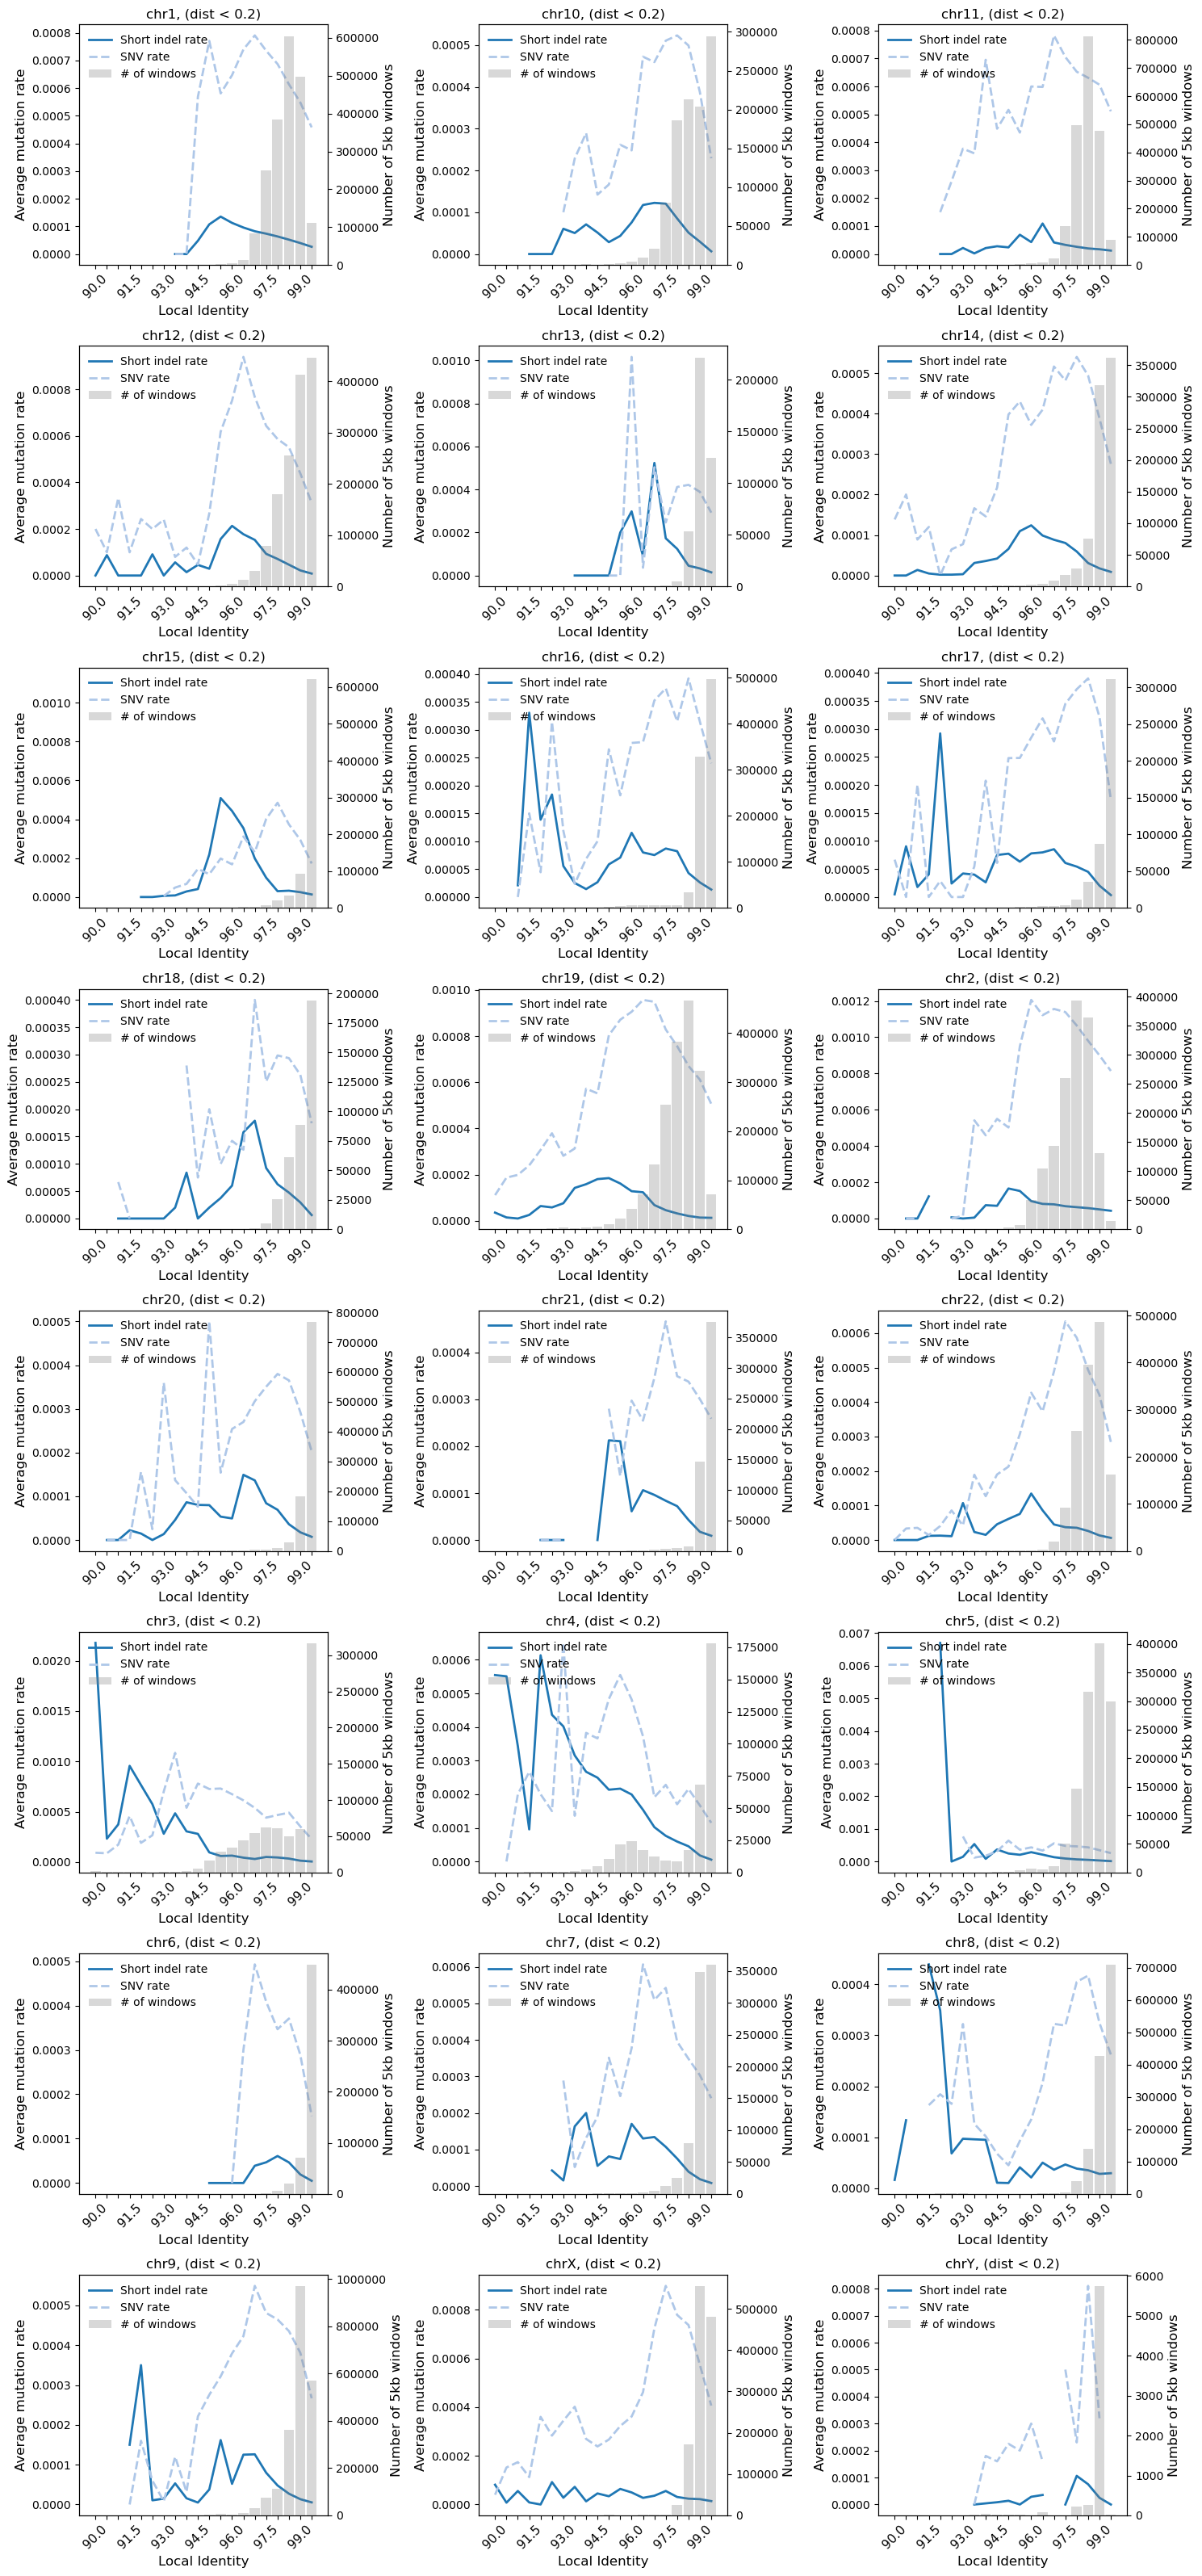

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import ScalarFormatter

# ----------------------------
# Binning
# ----------------------------
bins = np.arange(90, 100.5, 0.5)
bin_left_edges = bins[:-1]
N = 3  # show every Nth x tick

all_short_indels_df['identity_bin'] = pd.cut(
    all_short_indels_df['local_identity'], bins=bins, include_lowest=True
)
all_snvs_df['identity_bin'] = pd.cut(
    all_snvs_df['local_identity'], bins=bins, include_lowest=True
)

# ----------------------------
# Aggregate short indels
# ----------------------------
short_avg = (
    all_short_indels_df
    .groupby(['chr', 'identity_bin'])
    .agg(
        short_indel_rate_avg=('tri_rate', 'mean'),
        window_count=('tri_rate', 'count')
    )
    .reset_index()
)

# ----------------------------
# Aggregate SNVs
# ----------------------------
snv_avg = (
    all_snvs_df
    .groupby(['chr', 'identity_bin'])
    .agg(
        SNV_rate_avg=('SNV_rate', 'mean')
    )
    .reset_index()
)

# ----------------------------
# Merge
# ----------------------------
chrom_avg = pd.merge(
    short_avg,
    snv_avg,
    on=['chr', 'identity_bin'],
    how='inner'
)

chrom_avg['bin_left'] = chrom_avg['identity_bin'].apply(lambda x: x.left)

# ----------------------------
# Plot setup
# ----------------------------
chromosomes = chrom_avg['chr'].unique()
n_chroms = len(chromosomes)

n_cols = 3
n_rows = int(np.ceil(n_chroms / n_cols))

fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(n_cols * 5, n_rows * 4),
    sharey=False
)
axes = axes.flatten()

colors = plt.cm.tab20.colors

# ----------------------------
# Plot per chromosome
# ----------------------------
for i, chrom in enumerate(chromosomes):
    ax = axes[i]
    chrom_data = chrom_avg[chrom_avg['chr'] == chrom]

    # Short indel rate
    l1, = ax.plot(
        chrom_data['bin_left'],
        chrom_data['short_indel_rate_avg'],
        color=colors[0],
        linewidth=2,
        label='Short indel rate'
    )

    # SNV rate
    l2, = ax.plot(
        chrom_data['bin_left'],
        chrom_data['SNV_rate_avg'],
        color=colors[1],
        linestyle='--',
        linewidth=2,
        label='SNV rate'
    )

    # Window counts (right axis)
    ax2 = ax.twinx()
    b1 = ax2.bar(
        chrom_data['bin_left'],
        chrom_data['window_count'],
        width=0.45,
        alpha=0.3,
        color='gray',
        label='Number of windows'
    )

    # Labels
    ax.set_ylabel('Average mutation rate', fontsize=12)
    ax2.set_ylabel('Number of 5kb windows', fontsize=12)
    ax.set_xlabel('Local Identity', fontsize=12)

    # Formatting
    ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=False))
    ax.ticklabel_format(axis='y', style='plain')
    ax.yaxis.get_offset_text().set_visible(False)

    ax2.yaxis.set_major_formatter(ScalarFormatter(useMathText=False))
    ax2.ticklabel_format(axis='y', style='plain')
    ax2.yaxis.get_offset_text().set_visible(False)

    tick_labels = [
        str(bin_left_edges[j]) if j % N == 0 else ''
        for j in range(len(bin_left_edges))
    ]
    ax.set_xticks(bin_left_edges)
    ax.set_xticklabels(tick_labels, rotation=45, fontsize=11)

    ax.set_title(
        f'{chrom}, (dist < 0.2)',
        fontsize=12
    )

    ax.legend(
        handles=[l1, l2, b1],
        labels=[
            'Short indel rate',
            'SNV rate',
            '# of windows'
        ],
        loc='upper left',
        frameon=False
    )

# Remove empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


### SVs - triangles only 

In [ ]:
base_path = Path("/private/groups/patenlab/mira/centrolign/analysis/CDR_variant_regression/SVs_pairwise_all/")

# BED column names as given
columns = [
    "contig",
    "start",
    "end",
    "local_identity",
    "CDR_dist",
    "par_count",
    "par_rate",
    "trap_count",
    "trap_rate",
    "tri_count",
    "tri_rate"
]

dfs = []

for chr_dir in base_path.glob("chr*"):
    if not chr_dir.is_dir():
        continue

    chr_name = chr_dir.name

    for bed_file in chr_dir.glob("*.bed"):
        # Extract sample names
        name_part = bed_file.name.split(".all_short_indel_counts.bed")[0]
        sample1, sample2 = name_part.split("_", 1)
        sample_pair = "_".join(sorted([sample1, sample2]))

        # Skip pairs not in allowed set
        if sample_pair not in allowed_pairs:
            continue

        df = pd.read_csv(
            bed_file,
            sep="\t",
            header=None,
            names=columns,
        )

        df["chr"] = chr_name
        df["sample1"] = sample1
        df["sample2"] = sample2
        df["sample_pair"] = sample_pair

        dfs.append(df)

# Combine only the filtered data
all_SVs_df = pd.concat(dfs, ignore_index=True)

In [5]:
base_path = Path("/private/groups/patenlab/mira/centrolign/analysis/CDR_variant_regression/SVs_pairwise_all/")

# BED column names as given
columns = [
    "contig",
    "start",
    "end",
    "local_identity",
    "CDR_dist",
    "par_count",
    "par_rate",
    "trap_count",
    "trap_rate",
    "tri_count",
    "tri_rate"
]

dfs = []

for chr_dir in base_path.glob("chr*"):
    if not chr_dir.is_dir():
        continue

    chr_name = chr_dir.name

    for bed_file in chr_dir.glob("*.bed"):
        # Extract sample names
        name_part = bed_file.name.split(".all_SV_counts.bed")[0]
        sample1, sample2 = name_part.split("_", 1)
        sample_pair = "_".join(sorted([sample1, sample2]))

        # Skip pairs not in allowed set
        if sample_pair not in allowed_pairs:
            continue

        df = pd.read_csv(
            bed_file,
            sep="\t",
            header=None,
            names=columns,
        )

        df["chr"] = chr_name
        df["sample1"] = sample1
        df["sample2"] = sample2
        df["sample_pair"] = sample_pair

        dfs.append(df)

# Combine only the filtered data
all_SVs_df = pd.concat(dfs, ignore_index=True)

/data/tmp/ipykernel_1490520/3457111549.py:51: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_SVs_df = pd.concat(dfs, ignore_index=True)


In [6]:
all_SVs_df.head()

,contig,start,end,local_identity,CDR_dist,par_count,par_rate,trap_count,trap_rate,tri_count,tri_rate,chr,sample1,sample2,sample_pair
0,HG00741#2#JAHALX020000030.1,50986082,50991081,97.57,1503954,0,0.0,0,0.0,0,0.000000,chr11,HG00741.2,HG00735.1,HG00735.1_HG00741.2
1,HG00741#2#JAHALX020000030.1,50991082,50996081,96.74,1498954,0,0.0,0,0.0,0,0.000000,chr11,HG00741.2,HG00735.1,HG00735.1_HG00741.2
2,HG00741#2#JAHALX020000030.1,50996082,51001081,96.67,1493954,0,0.0,0,0.0,0,0.000000,chr11,HG00741.2,HG00735.1,HG00735.1_HG00741.2
3,HG00741#2#JAHALX020000030.1,51001082,51006081,96.50,1488954,0,0.0,0,0.0,0,0.000000,chr11,HG00741.2,HG00735.1,HG00735.1_HG00741.2
4,HG00741#2#JAHALX020000030.1,51006082,51011081,97.15,1483954,0,0.0,0,0.0,1,0.169634,chr11,HG00741.2,HG00735.1,HG00735.1_HG00741.2


/data/tmp/ipykernel_1490520/319909664.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  chrom_avg = all_SVs_df.groupby(['chr', 'identity_bin']).agg(


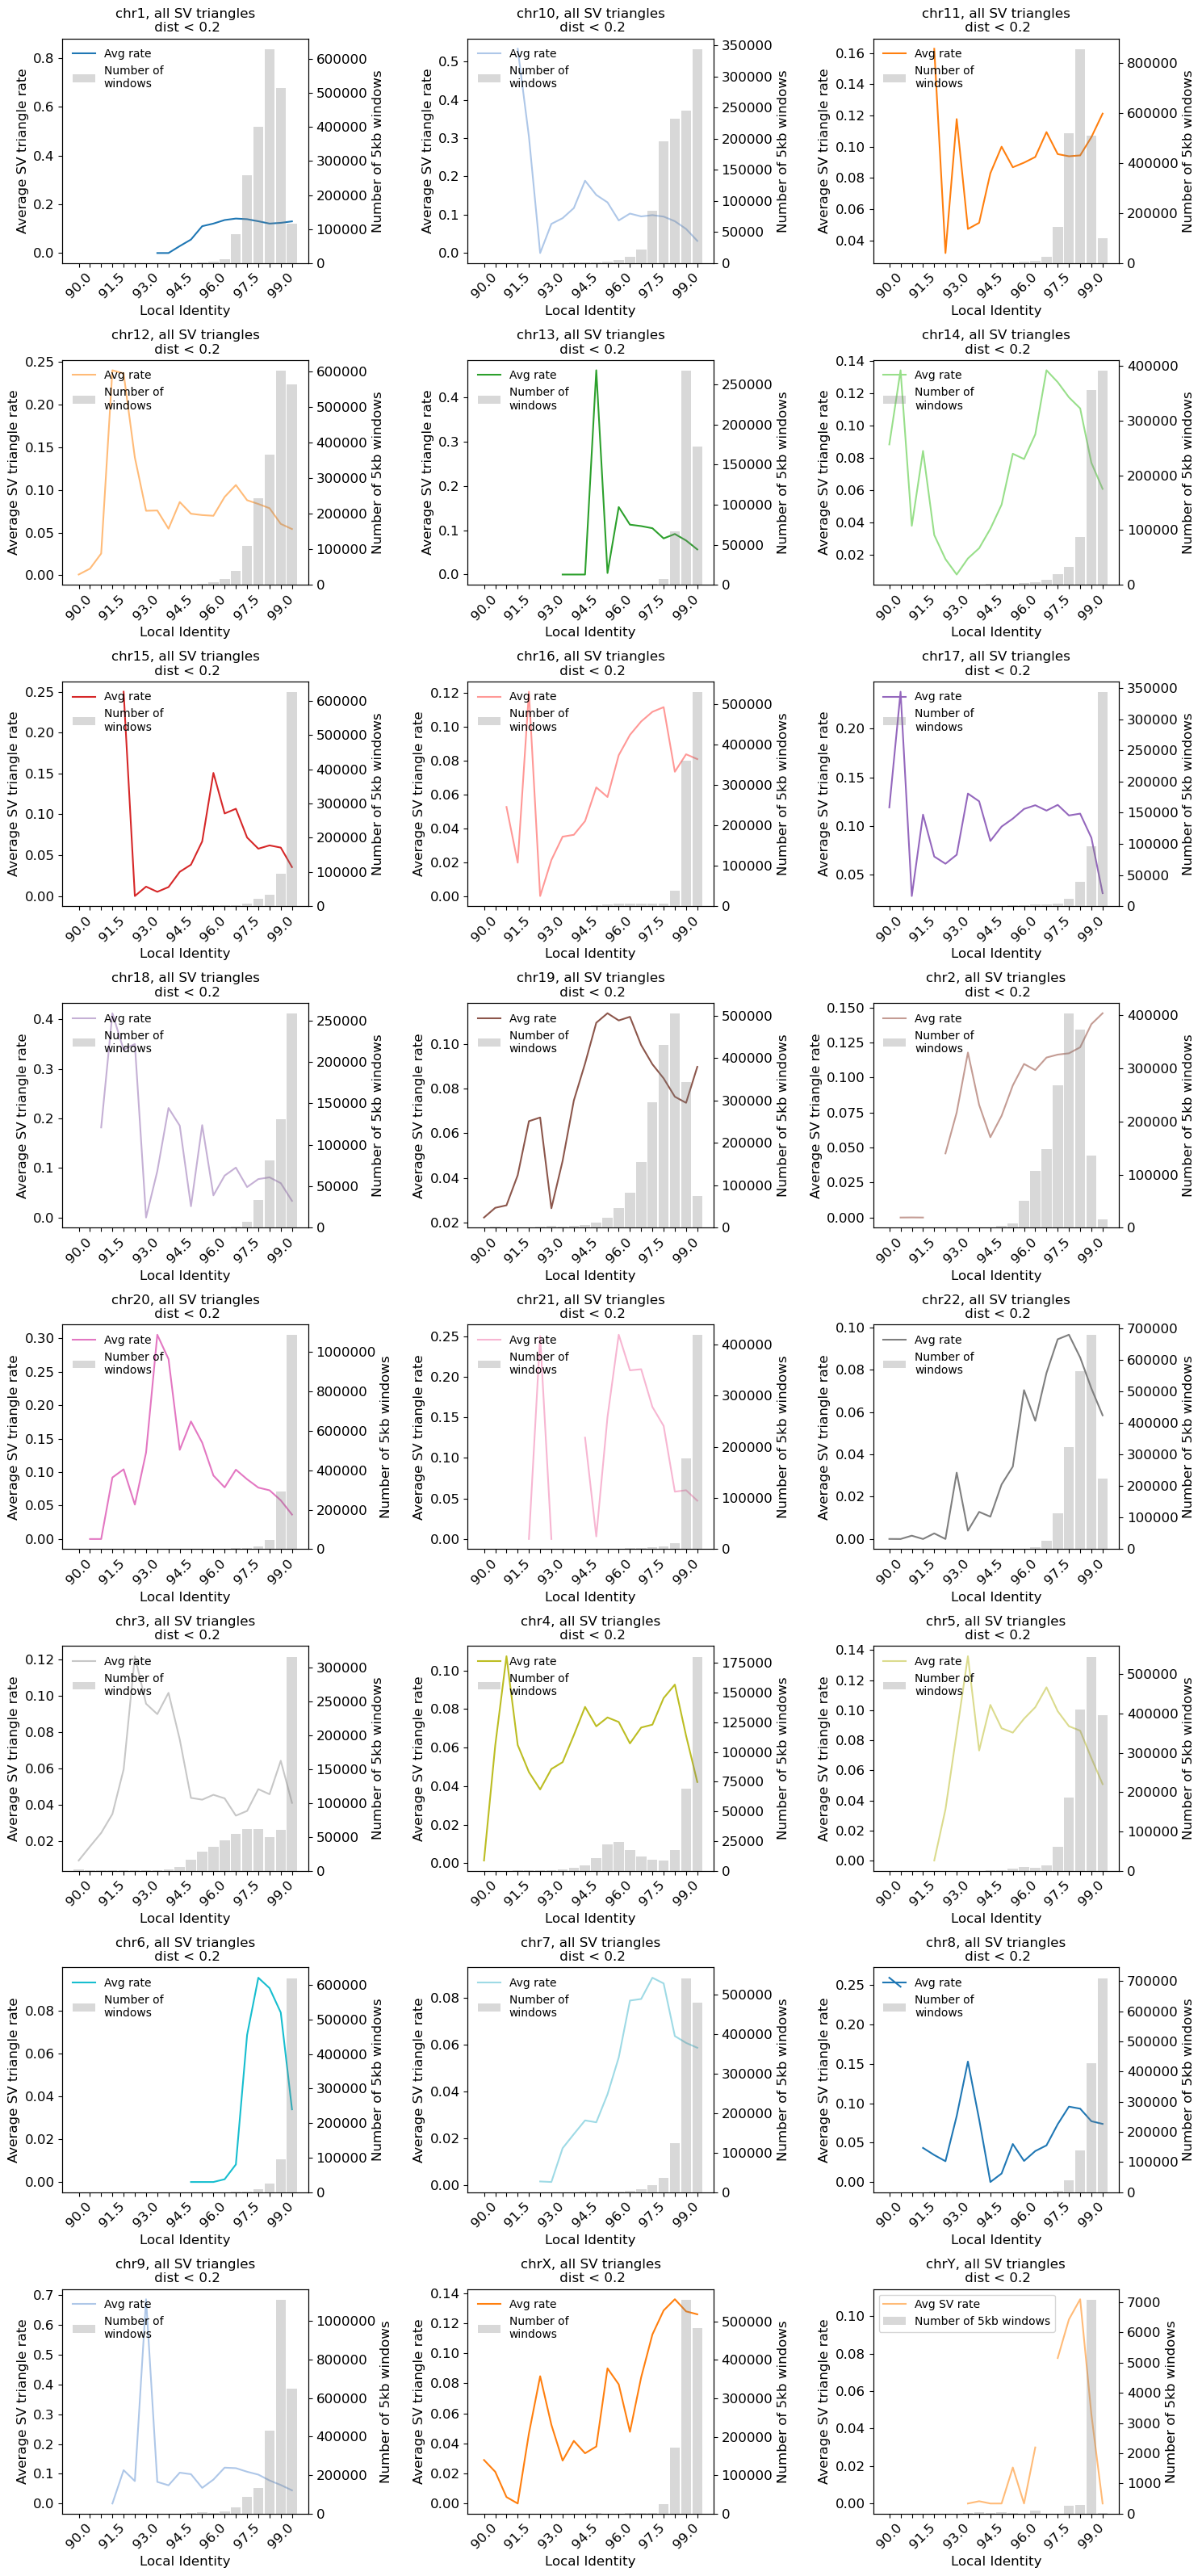

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import ScalarFormatter

# Create bins from 85 to 100 in steps of 0.5
bins = np.arange(90, 100.5, 0.5)  # bin edges
bin_left_edges = bins[:-1]  # left edges for plotting and labels

# Add 'identity_bin' column
all_SVs_df['identity_bin'] = pd.cut(all_SVs_df['local_identity'], bins=bins, include_lowest=True)

# Compute average SNV rate per chromosome per bin
chrom_avg = all_SVs_df.groupby(['chr', 'identity_bin']).agg(
    SV_rate_avg=('tri_rate', 'mean'),
    window_count=('tri_rate', 'count')  # number of windows in the bin
).reset_index()

# Convert 'identity_bin' (intervals) to numeric x-values: use left edge
chrom_avg['bin_left'] = chrom_avg['identity_bin'].apply(lambda x: x.left)

# List of chromosomes
chromosomes = chrom_avg['chr'].unique()
n_chroms = len(chromosomes)

# Determine grid size for subplots
n_cols = 3
n_rows = int(np.ceil(n_chroms / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*5, n_rows*4), sharey=False)
axes = axes.flatten()

# Colormap for chromosome lines
colors = plt.cm.tab20.colors  # up to 20 distinct colors
N = 3  # Show every Nth x-axis label

for i, chrom in enumerate(chromosomes):
    ax = axes[i]
    chrom_data = chrom_avg[chrom_avg['chr'] == chrom]
    
    l1, = ax.plot(
        chrom_data['bin_left'],
        chrom_data['SV_rate_avg'],
        color=colors[i % len(colors)],
        label='Avg SV rate'
    )
    
    ax2 = ax.twinx()
    l2 = ax2.bar(
        chrom_data['bin_left'],
        chrom_data['window_count'],
        width=0.45,
        alpha=0.3,
        color='gray',
        label='Number of 5kb windows'
    )
    
    ax.set_ylabel('Average SV triangle rate',fontsize=12)
    ax2.set_ylabel('Number of 5kb windows',fontsize=12)

    # Disable scientific notation on left y-axis
    ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=False))
    ax.ticklabel_format(axis='y', style='plain')
    ax.yaxis.get_offset_text().set_visible(False)

    # Disable scientific notation on right y-axis
    ax2.yaxis.set_major_formatter(ScalarFormatter(useMathText=False))
    ax2.ticklabel_format(axis='y', style='plain')
    ax2.yaxis.get_offset_text().set_visible(False)

    ax.grid(False)
    ax2.grid(False)

    # X ticks
    tick_labels = [
        str(bin_left_edges[j]) if j % N == 0 else ''
        for j in range(len(bin_left_edges))
    ]
    ax.set_xticks(bin_left_edges)
    ax.set_xticklabels(tick_labels, rotation=45,fontsize=12)
    ax.tick_params(axis='both', labelsize=12)
    ax2.tick_params(axis='y', labelsize=12)

    ax.set_xlabel("Local Identity",fontsize=12)
    ax.set_title(f'{chrom}, all SV triangles\n dist < 0.2',fontsize=12)

    ax.legend(
        handles=[l1, l2],
        labels=['Avg rate', 'Number of\nwindows'],
        loc='upper left',
        frameon=False
    )


# Remove empty subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

# Legend (combined)
lines, labels1 = ax.get_legend_handles_labels()
bars, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines + bars, labels1 + labels2, loc='upper left')

plt.tight_layout()
plt.show()

